Ring Resonantor

In [2]:
import gplugins.modes as gmode
import numpy as np
import matplotlib.pyplot as plt
import meep as mp
import gdsfactory as gf
import gplugins.gmeep as gm
import gdsfactory.cross_section as xs

Using MPI version 4.1, 1 processes
2025-10-12 00:27:25.505 | INFO     | gplugins.gmeep:<module>:39 - Meep '1.31.0' installed at ['/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep']


# Ring Resonator from gdsfactory

/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/gdsfactory/components/couplers/coupler90.py:42: UserWarning: {'radius': 10.0} ignored for cross_section 'strip'
  x = gf.get_cross_section(cross_section, radius=radius)


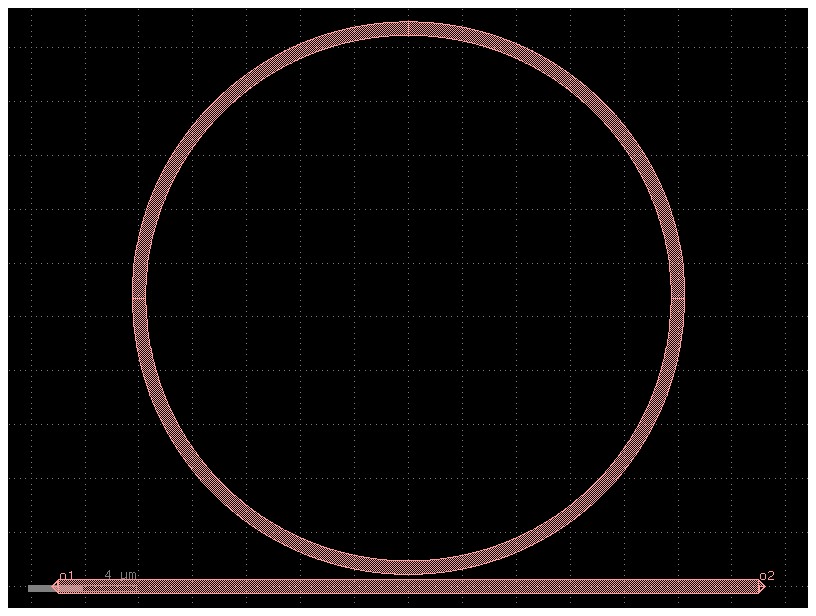

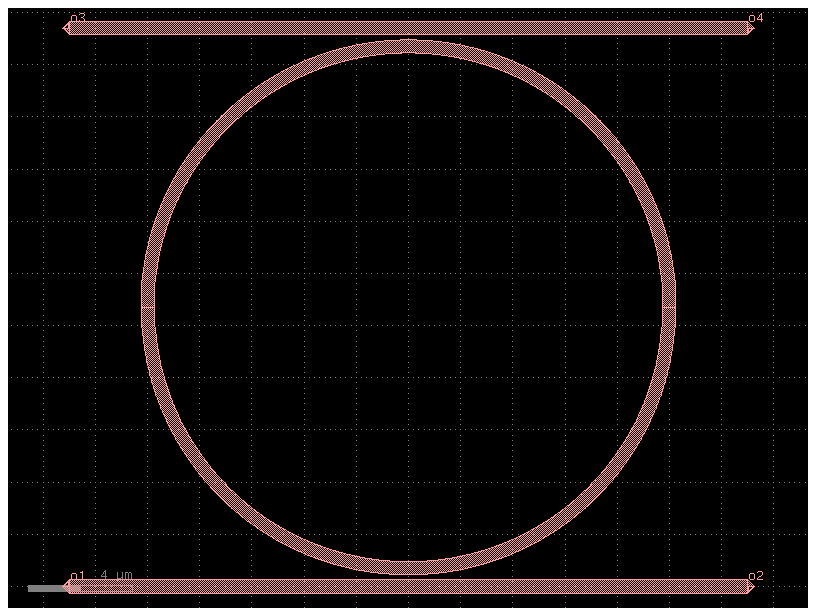

In [2]:
my_cross_section = xs.strip(width=0.5, radius=10) 
ring_resonator_single = gf.components.ring_single(
    gap=0.2,
    # radius=100,
    length_x=0,
    length_y=0,
    cross_section=my_cross_section,
    bend=gf.components.bend_circular,
)
ring_resonator_single.draw_ports()
ring_resonator_single.plot()

ring_resonator_double = gf.components.ring_double(
    gap=0.2,
    # radius=10,
    length_x=0,
    length_y=0,
    cross_section=my_cross_section,
    bend=gf.components.bend_circular,
)
ring_resonator_double.draw_ports()
ring_resonator_double.plot()

In [6]:
scene = ring_resonator_double.to_3d()
scene.show()

## S-paramter for all pass ring resonator. 

Optimized for resonace at 1.55um

## Analytical discriprion

**Resonace**:

$L = 2\pi R$

$\beta L = m2\pi$; $\beta = \frac{2\pi n}{\lambda}$

Let, $\lambda=1.55 \mu m$, then

$m=\frac{2\pi R n_{eff}}{\lambda}$

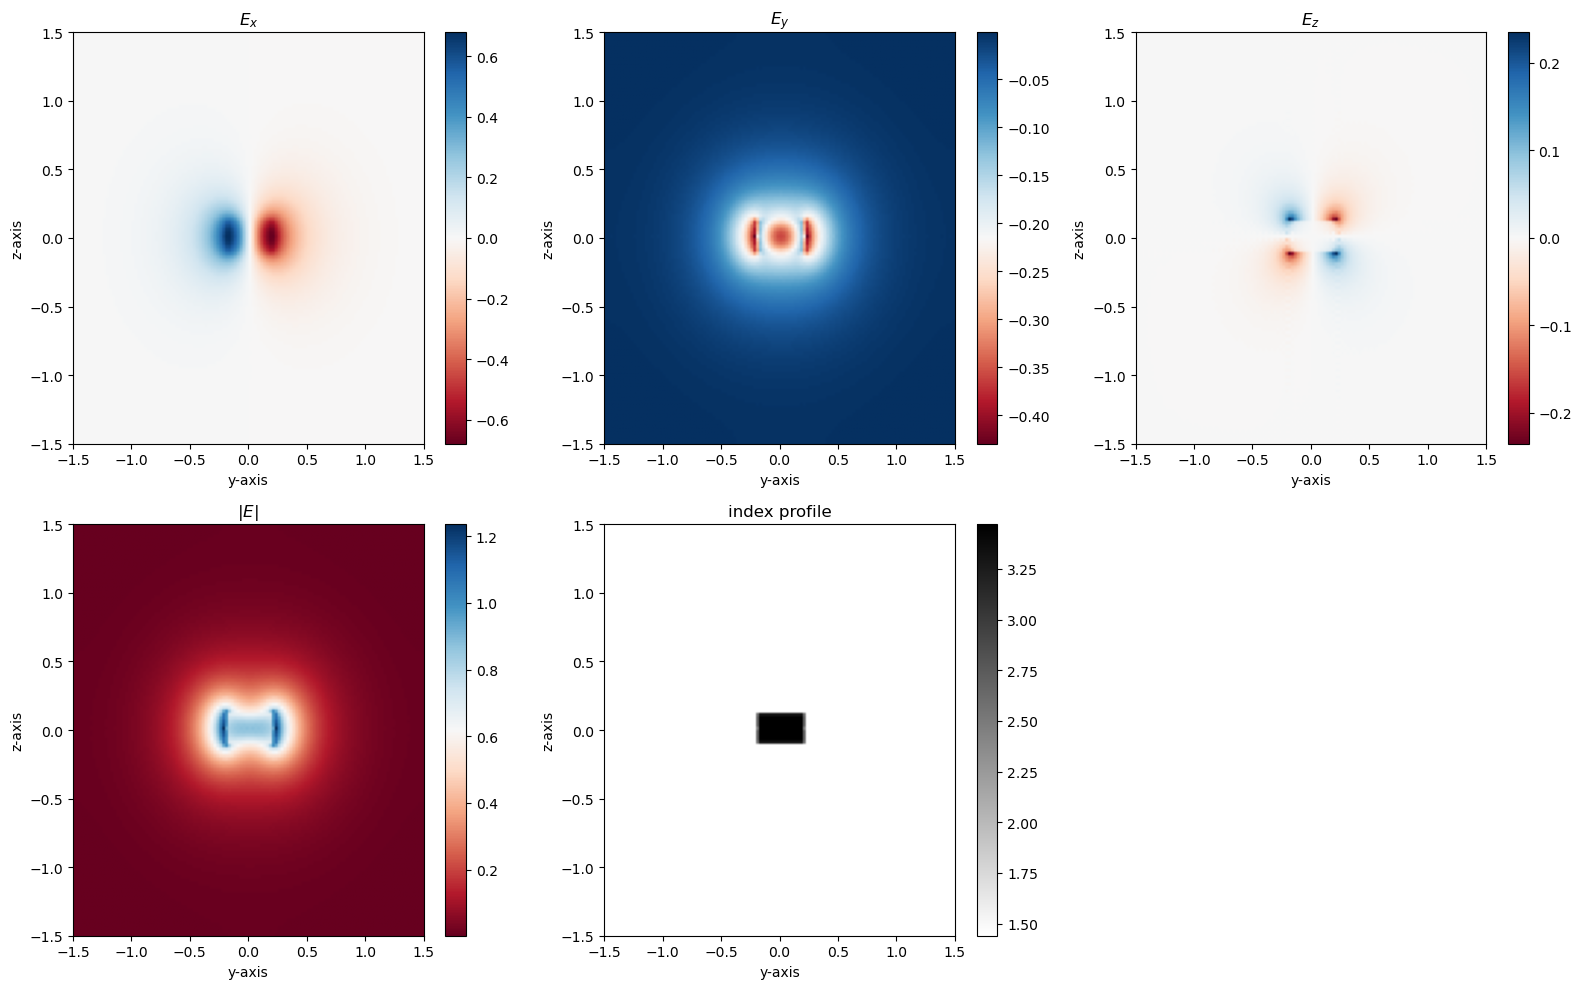

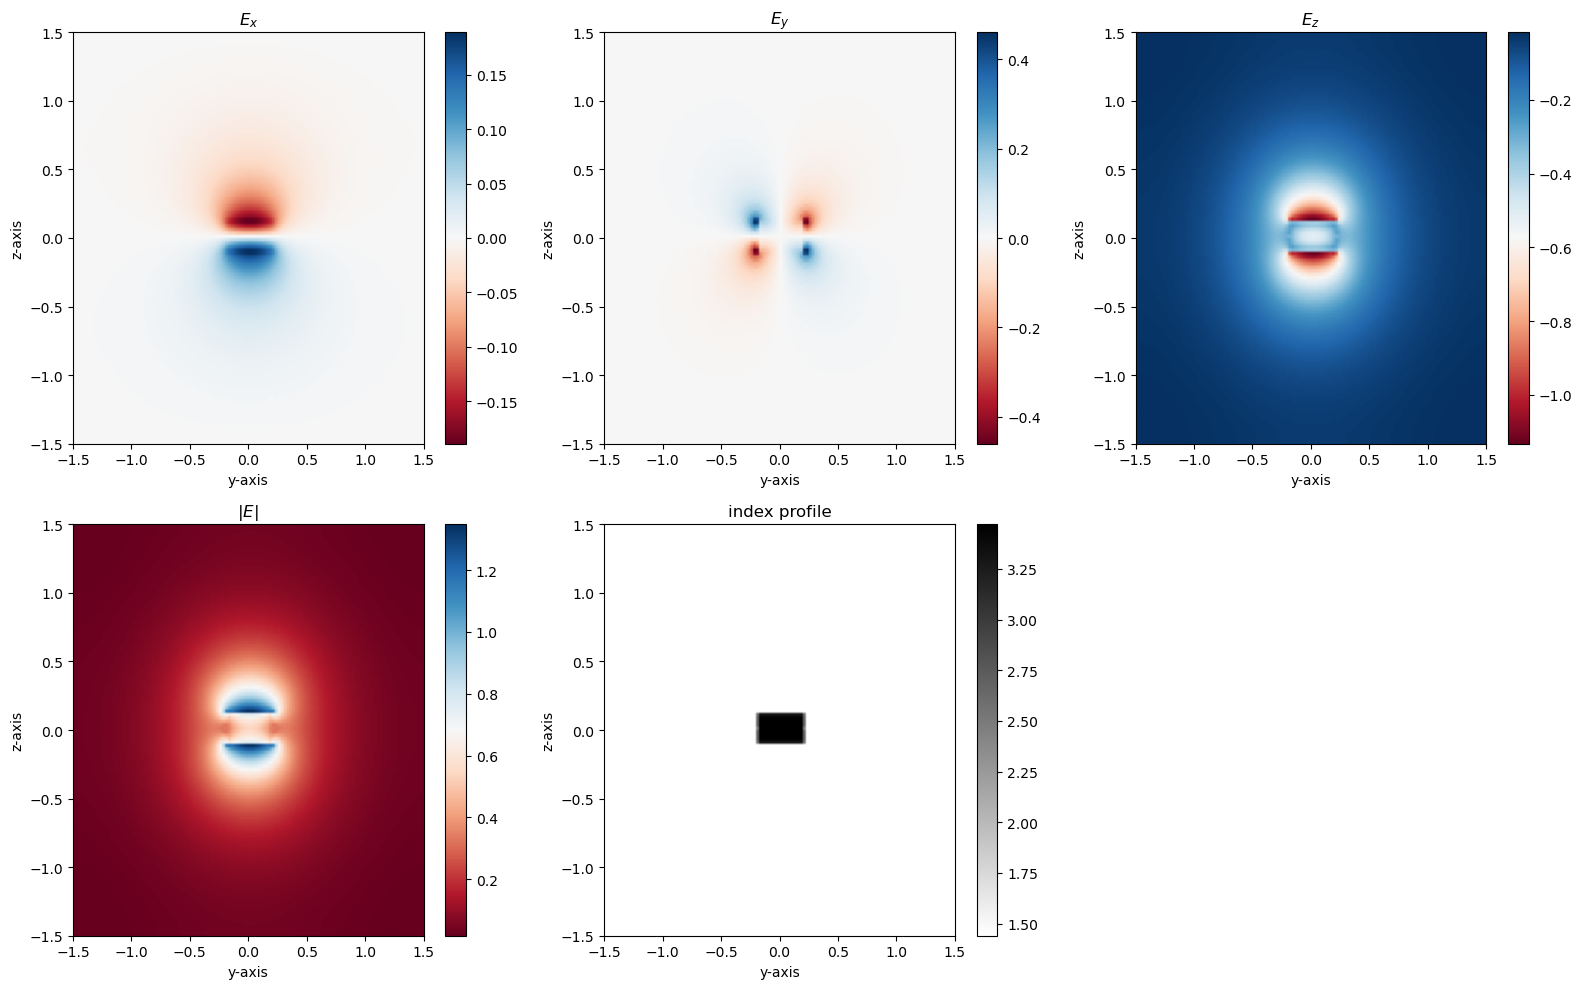

Effective index of mode 1 =  2.212251105731657
Effective index of mode 2 =  1.6813883197157091
The group index = 4.276256881279943


In [3]:
# Calcualte neff and group index using mode solver from gplugins
modes = gmode.find_modes_waveguide(
    parity=mp.NO_PARITY,
    core_width=0.4,
    core_material=3.47,
    clad_material=1.44,
    core_thickness=0.22,
    resolution=40,
    sy=3,
    sz=3,
    nmodes=4,
)
m1 = modes[1]
m2 = modes[2]
m3 = modes[3]

m1.plot_e_all()
m2.plot_e_all()

print("Effective index of mode 1 = ", m1.neff)
print("Effective index of mode 2 = ", m2.neff)

# Calcualting the group index
disp = gmode.find_mode_dispersion(
    wavelength=1.55,
    wavelength_step = 0.01,
    core='Si',
    clad='SiO2',
    mode_number=1
            )
print('The group index =', disp.ng)

In [4]:
R = 10 # Radius of the ring
lam = 1.55
neff = m1.neff # effective index of mode 1
ng = disp.ng # Group index 
mode_num = 2*np.pi*R*neff/lam # mode number 

# Free spectral range (FSR)
FSR = lam**2/(2*np.pi*R*ng)

print('mode number = ', mode_num)
print('Free spectral range =', FSR,'um')

mode number =  89.67731382790285
Free spectral range = 0.008941692732543 um


## Meep simulation

In [69]:
%%writefile Ring_MPI_sim.py
import gplugins.modes as gmode
import numpy as np
import matplotlib.pyplot as plt
import meep as mp
import gdsfactory as gf
import gplugins.gmeep as gm
import gdsfactory.cross_section as xs

# mp.verbosity(0)

my_cross_section = xs.strip(width=0.5, radius=10) 
ring_resonator_single = gf.components.ring_single(
    gap=0.1,
    # radius=100,
    length_x=0,
    length_y=0,
    cross_section=my_cross_section,
    bend=gf.components.bend_circular,
)

# Set up frequency points for simulation
npoints = 10000
lcen = 1.55
dlam = 0.03
wl = np.linspace(lcen - dlam / 2, lcen + dlam / 2, npoints)
fcen = 1 / lcen
fwidth = 3 * dlam / lcen**2
fpoints = 1 / wl

# Center frequency mode_parity
mode_parity = mp.EVEN_Y + mp.ODD_Z
dpml = 1
dpad = 1
resolution = 30

# Define materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

# Cell size
cell_size = mp.Vector3(ring_resonator_single.xsize + 2 * dpml, ring_resonator_single.ysize + 2 * dpml + 2 * dpad, 0)

# Create the ring resonator component
ring_resonator_single = gf.components.extend_ports(ring_resonator_single, port_names=["o1", "o2"], length=2)
ring_resonator_single = ring_resonator_single.copy()
ring_resonator_single.flatten()
ring_resonator_single.center = (0, 0)

# Get geometry from component
geometry = gm.get_meep_geometry.get_meep_geometry_from_component(ring_resonator_single)

geometry = [
    mp.Prism(geom.vertices, geom.height, geom.axis, geom.center, material=Si)
    for geom in geometry
]
# Source
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src=src,
        eig_band=1,
        eig_parity=mode_parity,
        eig_kpoint=mp.Vector3(1, 0, 0),
        direction=mp.NO_DIRECTION,
        size=mp.Vector3(0, 1),
        center=mp.Vector3(ring_resonator_single.ports["o1"].x + dpml + 2, ring_resonator_single.ports["o1"].y),
        amplitude=1
    ),
]

# Simulation
sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=[mp.PML(dpml)],
    sources=source,
    geometry=geometry,
    default_material=SiO2,
    # symmetries=[mp.Mirror(mp.Y)]
)

# Mode monitors
m1 = mp.Volume(
    center=mp.Vector3(ring_resonator_single.ports["o1"].x + dpml + 2 + 0.5, ring_resonator_single.ports["o1"].y),
    size=mp.Vector3(0, 1),
)
m2 = mp.Volume(
    center=mp.Vector3(ring_resonator_single.ports["o2"].x - dpml - 1 - 0.5, ring_resonator_single.ports["o2"].y),
    size=mp.Vector3(0, 1),
)

mode_monitor_1 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m1))
mode_monitor_2 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m2))
whole_dft = sim.add_dft_fields([mp.Ez], 0.6489713803621261, 0, 1, center=mp.Vector3(), size=cell_size)

# Only plot from master process
if mp.am_master():
    print(f"Running simulation with {mp.count_processors()} MPI processes...")
    sim.plot2D(labels=False)
    plt.savefig('simulation_geometry.png', dpi=150, bbox_inches='tight')
    plt.close()

# Run simulation
# sim.run(
#         until_after_sources=mp.stop_when_fields_decayed(
#             25, mp.Ez, 1e-2
#         )
#     )
sim.run(
    mp.at_every(2000, lambda sim: print(f"Time: {sim.meep_time():.1f}")),
    until_after_sources=mp.stop_when_dft_decayed(tol=1e-9, maximum_run_time=10000)
)

# Calculate S parameters
norm_mode_coeff = sim.get_eigenmode_coefficients(
    mode_monitor_1, [1], eig_parity=mode_parity
).alpha[0, :, 0]

port1_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_1, [1], eig_parity=mode_parity).alpha[0, :, 1]
    / norm_mode_coeff
)

port2_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_2, [1], eig_parity=mode_parity).alpha[0, :, 0]
    / norm_mode_coeff
)

# Get field data
eps_data = sim.get_epsilon()
ez_data = sim.get_dft_array(whole_dft, mp.Ez, 0)

# Save results (only from master process)
if mp.am_master():
    np.save('wavelengths.npy', wl)
    np.save('port1_coeff.npy', port1_coeff)
    np.save('port2_coeff.npy', port2_coeff)
    np.save('eps_data.npy', eps_data)
    np.save('ez_data.npy', ez_data)
    
    # Create field plot
    fig = plt.figure(figsize=(12, 8))
    ax_field = fig.add_subplot(1, 1, 1)
    ax_field.set_title("Steady State Fields")
    ax_field.imshow(
        np.flipud(np.transpose(eps_data)),
        interpolation="spline36",
        cmap="binary"
    )

    ax_field.imshow(
        np.flipud(np.transpose(np.real(ez_data))),
        interpolation="spline36",
        cmap="RdBu",
        alpha=0.9,
    )
    ax_field.axis("off")
    plt.savefig('steady_state_fields.png', dpi=150, bbox_inches='tight')
    plt.close()
    
    print("Simulation completed successfully!")
    print(f"Results saved to: wavelengths.npy, port1_coeff.npy, port2_coeff.npy, eps_data.npy, ez_data.npy")
    print(f"Plots saved to: simulation_geometry.png, steady_state_fields.png")

Overwriting Ring_MPI_sim.py


In [ ]:
!mpirun -np 24 python Ring_MPI_sim.py

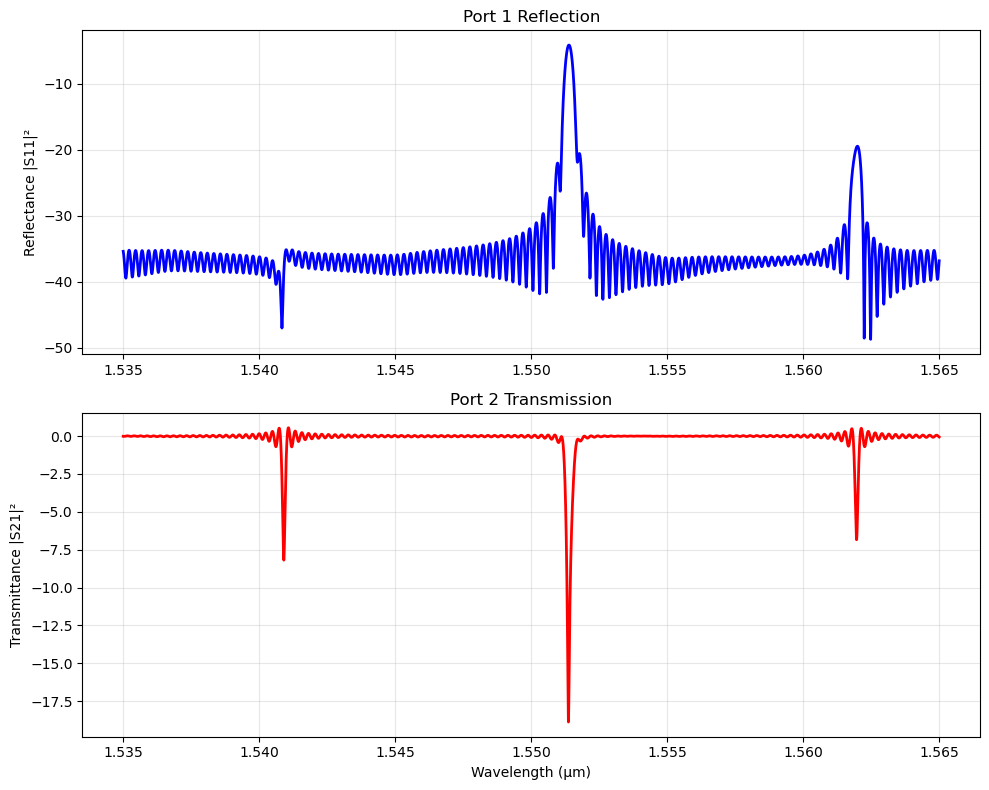

Peak transmission: 0.0129
Resonance wavelength: 1.5514 μm


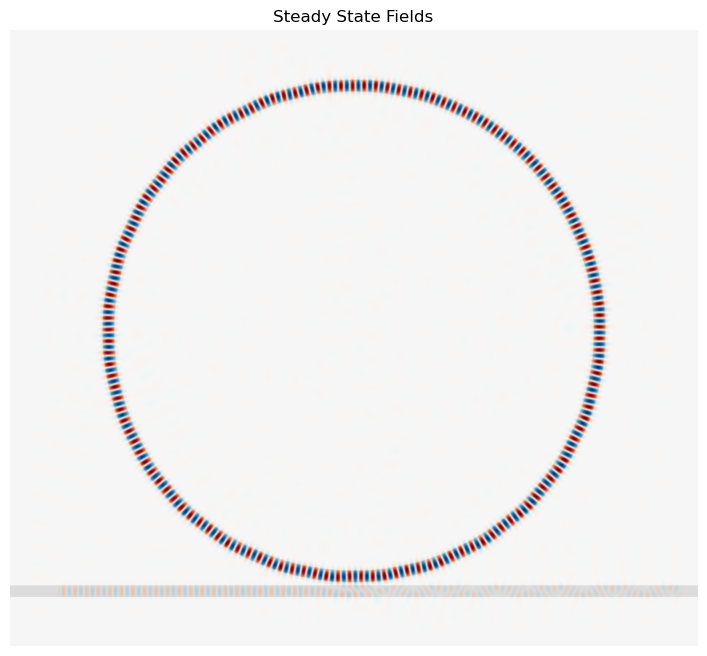

In [3]:

# Load results
wl = np.load('wavelengths.npy')
port1_coeff = np.load('port1_coeff.npy')
port2_coeff = np.load('port2_coeff.npy')
eps_data = np.load('eps_data.npy')
ez_data = np.load('ez_data.npy')

# Plot transmission spectrum
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# S11 (reflection)
ax1.plot(wl, 10*np.log10(np.abs(port1_coeff)**2), 'b-', linewidth=2)
ax1.set_ylabel('Reflectance |S11|²')
ax1.set_title('Port 1 Reflection')
ax1.grid(True, alpha=0.3)

# S21 (transmission)
ax2.plot(wl, 10*np.log10(np.abs(port2_coeff)**2), 'r-', linewidth=2)
ax2.set_xlabel('Wavelength (μm)')
ax2.set_ylabel('Transmittance |S21|²')
ax2.set_title('Port 2 Transmission')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('transmission_spectrum.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Peak transmission: {np.min(np.abs(port2_coeff)**2):.4f}")
print(f"Resonance wavelength: {wl[np.argmin(np.abs(port2_coeff)**2)]:.4f} μm")

fig = plt.figure(figsize=(12, 8))
ax_field = fig.add_subplot(1, 1, 1)
ax_field.set_title("Steady State Fields")
ax_field.imshow(
     np.flipud(np.transpose(eps_data)),
      interpolation="spline36",
      cmap="binary")
ax_field.imshow(
    np.flipud(np.transpose(np.real(ez_data))),
    interpolation="spline36",
    cmap="RdBu",
    alpha=0.9,
)
ax_field.axis("off")
plt.show()

FSR from MEEP FDTD

In [6]:
# index of the the resonaces
index = np.argsort(10*np.log10(np.abs(port2_coeff)**2))[:3]
FSR = wl[index[1]]-wl[index[2]]
print('FSR from meep', np.abs(FSR))

FSR from meep 6.000600059952177e-06


## Double ring resonator

In [7]:
%%writefile RingDob_MPI_sim.py
import gplugins.modes as gmode
import numpy as np
import matplotlib.pyplot as plt
import meep as mp
import gdsfactory as gf
import gplugins.gmeep as gm
import gdsfactory.cross_section as xs

# mp.verbosity(0)

my_cross_section = xs.strip(width=0.5, radius=10) 
ring_resonator_double = gf.components.ring_double(
    gap=0.1,
    # radius=100,
    length_x=0,
    length_y=0,
    cross_section=my_cross_section,
    bend=gf.components.bend_circular,
)

# Set up frequency points for simulation
npoints = 10000
lcen = 1.55
dlam = 0.03
wl = np.linspace(lcen - dlam / 2, lcen + dlam / 2, npoints)
fcen = 1 / lcen
fwidth = 3 * dlam / lcen**2
fpoints = 1 / wl

# Center frequency mode_parity
mode_parity = mp.EVEN_Y + mp.ODD_Z
dpml = 1
dpad = 1
resolution = 30

# Define materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

# Cell size
cell_size = mp.Vector3(ring_resonator_double.xsize + 2 * dpml, ring_resonator_double.ysize + 2 * dpml + 2 * dpad, 0)

# Create the ring resonator component
ring_resonator_double = gf.components.extend_ports(ring_resonator_double, port_names=["o1", "o2", "o3","o4"], length=2)
ring_resonator_double = ring_resonator_double.copy()
ring_resonator_double.flatten()
ring_resonator_double.center = (0, 0)

# Get geometry from component
geometry = gm.get_meep_geometry.get_meep_geometry_from_component(ring_resonator_double)

geometry = [
    mp.Prism(geom.vertices, geom.height, geom.axis, geom.center, material=Si)
    for geom in geometry
]
# Source
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src=src,
        eig_band=1,
        eig_parity=mode_parity,
        eig_kpoint=mp.Vector3(1, 0, 0),
        direction=mp.NO_DIRECTION,
        size=mp.Vector3(0, 1),
        center=mp.Vector3(ring_resonator_double.ports["o1"].x + dpml + 2, ring_resonator_double.ports["o1"].y),
        amplitude=1
    ),
]

# Simulation
sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=[mp.PML(dpml)],
    sources=source,
    geometry=geometry,
    default_material=SiO2,
    # symmetries=[mp.Mirror(mp.Y)]
)

# Mode monitors
m1 = mp.Volume(
    center=mp.Vector3(ring_resonator_double.ports["o1"].x + dpml + 2 + 0.5, ring_resonator_double.ports["o1"].y),
    size=mp.Vector3(0, 1),
)
m2 = mp.Volume(
    center=mp.Vector3(ring_resonator_double.ports["o2"].x - dpml - 1 - 0.5, ring_resonator_double.ports["o2"].y),
    size=mp.Vector3(0, 1),
)
m3 = mp.Volume(
    center=mp.Vector3(ring_resonator_double.ports["o3"].x + dpml + 2 + 0.5, ring_resonator_double.ports["o3"].y),
    size=mp.Vector3(0, 1),
)
m4 = mp.Volume(
    center=mp.Vector3(ring_resonator_double.ports["o4"].x - dpml - 1 - 0.5, ring_resonator_double.ports["o4"].y),
    size=mp.Vector3(0, 1),
)
mode_monitor_1 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m1))
mode_monitor_2 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m2))
mode_monitor_3 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m3))
mode_monitor_4 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m4))
whole_dft = sim.add_dft_fields([mp.Ez], 0.6402048655569782, 0, 1, center=mp.Vector3(), size=cell_size)

# Only plot from master process
if mp.am_master():
    print(f"Running simulation with {mp.count_processors()} MPI processes...")
    sim.plot2D(labels=False)
    plt.savefig('RingDob_simulation_geometry.png', dpi=150, bbox_inches='tight')
    plt.close()

# Run simulation
# sim.run(
#         until_after_sources=mp.stop_when_fields_decayed(
#             25, mp.Ez, 1e-2
#         )
#     )
sim.run(
    mp.at_every(2000, lambda sim: print(f"Time: {sim.meep_time():.1f}")),
    until_after_sources=mp.stop_when_dft_decayed(tol=1e-9, maximum_run_time=5000)
)

# Calculate S parameters
norm_mode_coeff = sim.get_eigenmode_coefficients(
    mode_monitor_1, [1], eig_parity=mode_parity
).alpha[0, :, 0]

port1_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_1, [1], eig_parity=mode_parity).alpha[0, :, 1]
    / norm_mode_coeff
)

port2_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_2, [1], eig_parity=mode_parity).alpha[0, :, 0]
    / norm_mode_coeff
)

port3_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_3, [1], eig_parity=mode_parity).alpha[0, :, 1]
    / norm_mode_coeff
)
port4_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_4, [1], eig_parity=mode_parity).alpha[0, :, 0]
    / norm_mode_coeff
)

# Get field data
eps_data = sim.get_epsilon()
ez_data = sim.get_dft_array(whole_dft, mp.Ez, 0)

# Save results (only from master process)
if mp.am_master():
    np.save('RingDob_wavelengths.npy', wl)
    np.save('RingDob_port1_coeff.npy', port1_coeff)
    np.save('RingDob_port2_coeff.npy', port2_coeff)
    np.save('RingDob_port3_coeff.npy', port3_coeff)
    np.save('RingDob_port4_coeff.npy', port4_coeff)
    np.save('RingDob_eps_data.npy', eps_data)
    np.save('RingDob_ez_data.npy', ez_data)
    
    # Create field plot
    fig = plt.figure(figsize=(12, 8))
    ax_field = fig.add_subplot(1, 1, 1)
    ax_field.set_title("Steady State Fields")
    ax_field.imshow(
        np.flipud(np.transpose(eps_data)),
        interpolation="spline36",
        cmap="binary"
    )
    ax_field.imshow(
        np.flipud(np.transpose(np.real(ez_data))),
        interpolation="spline36",
        cmap="RdBu",
        alpha=0.9,
    )
    ax_field.axis("off")
    plt.savefig('RingDob_steady_state_fields_.png', dpi=150, bbox_inches='tight')
    plt.close()
    
    print("Simulation completed successfully!")
    print(f"Results saved to: RingDob_wavelengths.npy, RingDob_port1_coeff.npy, RingDob_port2_coeff.npy, RingDob_eps_data.npy, RingDob_ez_data.npy")
    print(f"Plots saved to: simulation_geometry.png, steady_state_fields.png")

Overwriting RingDob_MPI_sim.py


In [ ]:
# Cell 3: Run with MPI 
!mpirun -np 24 python RingDob_MPI_sim.py

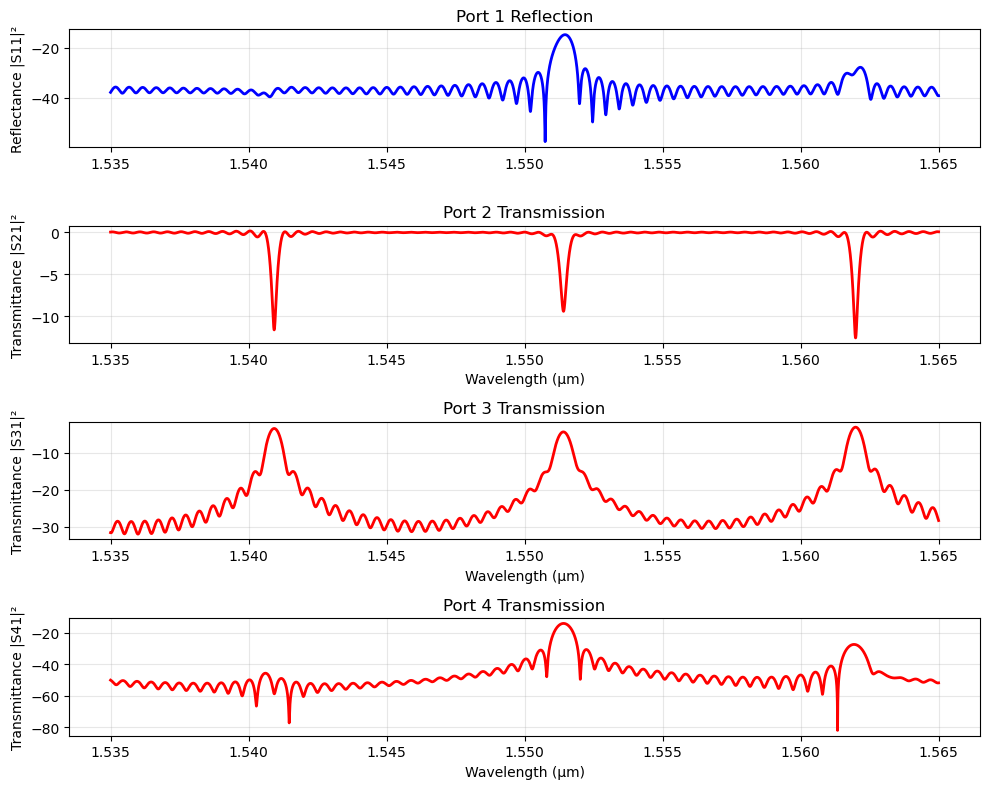

Peak transmission: 0.0551
Resonance wavelength: 1.5620 μm


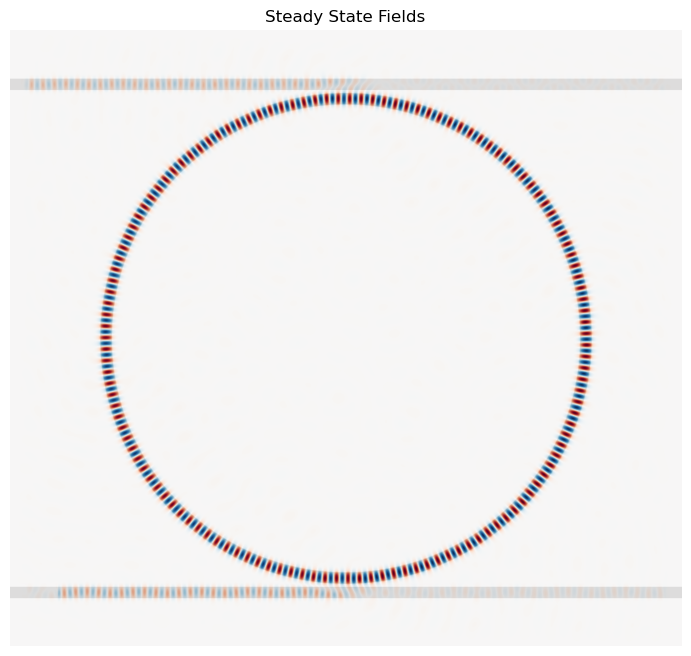

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Load results
wl = np.load('RingDob_wavelengths.npy')
port1_coeff = np.load('RingDob_port1_coeff.npy')
port2_coeff = np.load('RingDob_port2_coeff.npy')
port3_coeff = np.load('RingDob_port3_coeff.npy')
port4_coeff = np.load('RingDob_port4_coeff.npy')
eps_data = np.load('RingDob_eps_data.npy')
ez_data = np.load('RingDob_ez_data.npy')

# Plot transmission spectrum
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

# S11 (reflection)
ax1.plot(wl, 10*np.log10(np.abs(port1_coeff)**2), 'b-', linewidth=2)
ax1.set_ylabel('Reflectance |S11|²')
ax1.set_title('Port 1 Reflection')
ax1.grid(True, alpha=0.3)

# S21 (transmission)
ax2.plot(wl, 10*np.log10(np.abs(port2_coeff)**2), 'r-', linewidth=2)
ax2.set_xlabel('Wavelength (μm)')
ax2.set_ylabel('Transmittance |S21|²')
ax2.set_title('Port 2 Transmission')
ax2.grid(True, alpha=0.3)

# S31 (transmission)
ax3.plot(wl, 10*np.log10(np.abs(port3_coeff)**2), 'r-', linewidth=2)
ax3.set_xlabel('Wavelength (μm)')
ax3.set_ylabel('Transmittance |S31|²')
ax3.set_title('Port 3 Transmission')
ax3.grid(True, alpha=0.3)

# S41 (transmission)
ax4.plot(wl, 10*np.log10(np.abs(port4_coeff)**2), 'r-', linewidth=2)
ax4.set_xlabel('Wavelength (μm)')
ax4.set_ylabel('Transmittance |S41|²')
ax4.set_title('Port 4 Transmission')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('transmission_spectrum.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Peak transmission: {np.min(np.abs(port2_coeff)**2):.4f}")
print(f"Resonance wavelength: {wl[np.argmin(np.abs(port2_coeff)**2)]:.4f} μm")

fig = plt.figure(figsize=(12, 8))
ax_field = fig.add_subplot(1, 1, 1)
ax_field.set_title("Steady State Fields")
ax_field.imshow(
     np.flipud(np.transpose(eps_data)),
      interpolation="spline36",
      cmap="binary")
ax_field.imshow(
    np.flipud(np.transpose(np.real(ez_data))),
    interpolation="spline36",
    cmap="RdBu",
    alpha=0.9,
)
ax_field.axis("off")
plt.show()